## Data Preparation and LSTM Model Training for CMAPSS RUL Prediction
**Overview**
   
   This notebook documents the complete workflow for preparing rolling window time-series data and training a Long Short-Term Memory (LSTM) neural network to predict Remaining Useful Life (RUL) using the NASA CMAPSS dataset. The objective is to enable accurate and timely prediction of machinery lifespan as part of a predictive maintenance pipeline.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [5]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("rolling_window_sequences.npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17631, 30, 66)
y shape: (17631,)


In [6]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Example X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (14104, 30, 66) (14104,)
Val shape: (3527, 30, 66) (3527,)
Example X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 74.  41.  43.  33. 101.]


In [7]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)


#### LSTM Model Definition:
 - Input: (window_size, num_features)
 - Output: Single RUL value
 - Architecture: 1 LSTM layer + 1 Dense output layer
 - Hyperparameters: 64 units, 'tanh' activation, Adam optimizer, MSE loss

**Note:** For regression tasks, no activation on output layer

In [8]:
# LSTM Model for RUL Prediction
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()


c:\Users\win10\python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Training Setup: Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint(
    "best_lstm_model.keras", save_best_only=True, monitor="val_loss", verbose=1
)

In [10]:
# Model Training
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)


Epoch 1/50
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7637.0962
Epoch 1: val_loss improved from inf to 5885.82471, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 7621.2114 - val_loss: 5885.8247 - learning_rate: 0.0010
Epoch 2/50
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5488.3306
Epoch 2: val_loss improved from 5885.82471 to 4589.30713, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5480.2358 - val_loss: 4589.3071 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4283.1929
Epoch 3: val_loss improved from 4589.30713 to 3612.26050, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4282.1963 - val_loss: 3612.2605 - learning_rate: 0.0010
Epoch 4/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3371.3945
Epoch 4: val_loss improved from 3612.26050 to 2846.60034, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━

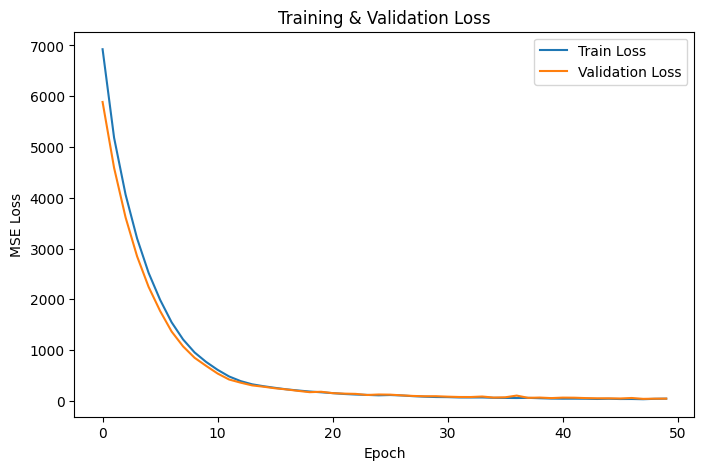

In [11]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


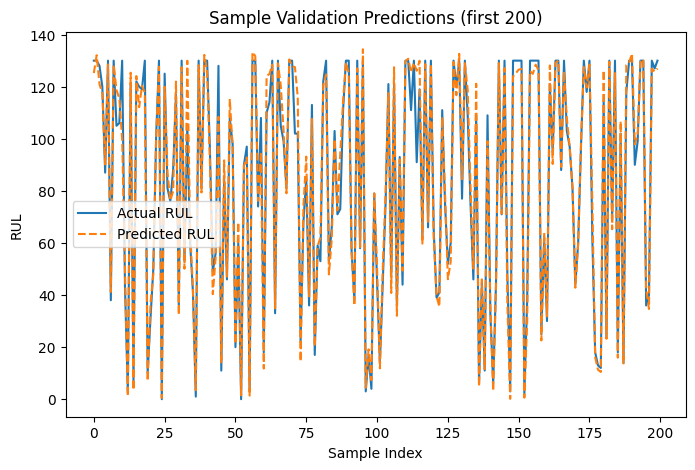

In [12]:
# Verify Model Predictions
val_pred = model.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()


## Overview
This notebook demonstrates the complete pipeline for preparing time-series data and training an LSTM neural network to predict the Remaining Useful Life (RUL) of turbofan engines using NASA's CMAPSS dataset. The process is designed to support predictive maintenance by forecasting machinery health.

---

## Data Preparation

- Loaded preprocessed rolling window sequences (`rolling_window_sequences.npy`) representing sensor features over 30-cycle windows.
- Loaded sequence metadata containing engine IDs, cycle numbers, and computed RUL targets (`sequence_metadata_with_RUL.csv`).
- Split data into training (80%) and validation (20%) sets, ensuring shape consistency and alignment between features and labels.
- Created TensorFlow datasets for efficient batching during model training.

---

## LSTM Model Training

- Defined a simple LSTM model with:
  - One LSTM layer (64 units) with `tanh` activation.
  - One dense output layer for regression output (RUL prediction).
- Compiled the model with Adam optimizer and Mean Squared Error (MSE) loss.
- Implemented training with these callbacks:
  - `EarlyStopping` with patience of 8 epochs to prevent overfitting.
  - `ReduceLROnPlateau` to reduce learning rate by half if validation loss plateaued for 4 epochs.
  - `ModelCheckpoint` to save the best model based on validation loss in `best_lstm_model.keras`.
- Trained the model for up to 50 epochs with batch size 64.
- Observed steady convergence in training and validation losses, indicating effective learning.

---

## Model Performance

- The training and validation loss curves confirm the model's ability to learn temporal dependencies and generalize well.
- The best model checkpoint was saved for downstream evaluation and deployment.
  
---

## Next Steps

- Use the saved model for rigorous evaluation on test data (Milestone 3).
- Experiment with advanced architectures, hyperparameter tuning, and data augmentations.
- Implement risk thresholding and alerting (Milestone 4).
- Develop visualization dashboards to monitor RUL trends in real-time (Milestone 5).

---

**Prepared by:** Mentor Satya Sai  
**Date:** September 10, 2025
